In [2]:
import os, re, math, random, datetime
import matplotlib.pyplot as plt
import cv2
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, concatenate, Conv2DTranspose, MaxPool2D, Reshape
from tensorflow.keras.optimizers import RMSprop, Adam
import imgaug.augmenters as iaa

path = "/home/bob/Desktop/pipeline/volume/train_keypoint/input_20211129"
typeNameList = ["type0", "type1_short", "type2_deflect", "data_1129"]

In [3]:
filePathList = []
for typeName in typeNameList:
    filePathList += list(map(lambda s:f"{path}/{typeName}/{s}", os.listdir(f"{path}/{typeName}")))
imgPathList = sorted(list(filter(lambda s:".jpg" in s,filePathList)))
xmlPathList = sorted(list(filter(lambda s:".xml" in s,filePathList)))
hmPathList = []
for imgPath in imgPathList:
    split = imgPath.split("/")
    hmPathList.append( imgPath.replace(split[-2],"heatmap").replace(split[-1],split[-2]+"_"+split[-1]) )  

os.system(f"mkdir {path}/heatmap")

for imgPath,xmlPath,hmPath in zip(imgPathList,xmlPathList,hmPathList):
    break  
    rawImg = plt.imread(imgPath)   
    img = cv2.resize(rawImg, (224,224))
    with open(xmlPath, "r") as f:
        txt = f.read()
        up_xmin, mid_xmin, down_xmin = re.findall("<xmin>([0-9]*)</xmin>", txt)
        up_xmax, mid_xmax, down_xmax = re.findall("<xmax>([0-9]*)</xmax>", txt)
        up_ymin, mid_ymin, down_ymin = re.findall("<ymin>([0-9]*)</ymin>", txt)
        up_ymax, mid_ymax, down_ymax = re.findall("<ymax>([0-9]*)</ymax>", txt)
    upx   = (int(up_xmin)+int(up_xmax))/2     /rawImg.shape[1] * 224
    midx  = (int(mid_xmin)+int(mid_xmax))/2   /rawImg.shape[1] * 224
    downx = (int(down_xmin)+int(down_xmax))/2 /rawImg.shape[1] * 224
    upy   = (int(up_ymin)+int(up_ymax))/2     /rawImg.shape[0] * 224
    midy  = (int(mid_ymin)+int(mid_ymax))/2   /rawImg.shape[0] * 224
    downy = (int(down_ymin)+int(down_ymax))/2 /rawImg.shape[0] * 224
    keypoints = [(0,upy,upx), (1,midy,midx), (2,downy,downx)]

    heatmap = np.zeros((224,224,3), dtype=np.float16)
    sigma = 5
    for channel,uy,ux in keypoints:
        gauss = lambda y,x: 1/(2*math.pi*sigma**2)*math.exp( -1/(2*sigma**2)*((x-ux)**2+(y-uy)**2) )
        for i in range(224):
            for j in range(224):
                heatmap[i][j][channel] = gauss(i,j)
    hmin, hmax = heatmap.min(), heatmap.max()
    heatmap = ((heatmap-hmin)/(hmax-hmin)*255).astype(int)
    cv2.imwrite( hmPath , heatmap)

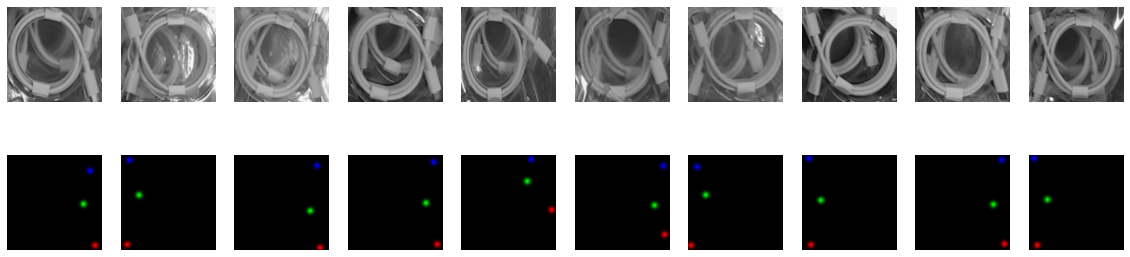

In [4]:
R = list(range(len(imgPathList)))
random.shuffle(R)
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow( plt.imread(imgPathList[R[i]]) )
    plt.axis('off')
    plt.subplot(2,10,10+i+1)
    plt.imshow( plt.imread(hmPathList[R[i]]) )
    plt.axis('off')
plt.show()

In [5]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=16, train=True):
        self.image_keys = image_keys # list[(str,str)] # all indices
        self.aug = aug               # aug
        self.batch_size = batch_size # int
        self.train = train
        self.on_epoch_end()
    def __len__(self):
        return len(self.image_keys) // self.batch_size
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys)) # np.array([int]) # all indices
        if self.train:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size] # np.array([int]) # indices of a batch
        image_keys_temp = [self.image_keys[k] for k in indexes]                         # np.array([str]) # imgName of a batch
        (images, keypoints) = self.__data_generation(image_keys_temp)
        return (images, keypoints)
    def __data_generation(self, image_keys_temp):
        batch_images = np.empty( (self.batch_size, 224, 224, 3), dtype="float" )
        batch_heatmap = np.empty( (self.batch_size, 224, 224, 3), dtype="float" )
        for i,(imgPath,hmPath) in enumerate(image_keys_temp):
            rawImg = cv2.imread(imgPath)
            hmImg  = cv2.imread(hmPath)
            
            probFliplr, probFlipud, probRotate = [ 0 if random.random()>=0.3 else 1 for j in range(3) ]
            aug = iaa.Sequential([
                iaa.Resize(224, interpolation="linear"),
                iaa.Sometimes( 0 if random.random()>=0.3 else 1, iaa.Affine(rotate=5)),
                iaa.Sometimes( 0 if random.random()>=0.3 else 1, iaa.Affine(scale=(0.7,0.7)))
            ])
            
            augRawImg = aug.augment_image(rawImg) 
            augHmImg  = aug.augment_image(hmImg)
            batch_images[i]  = (augRawImg-augRawImg.min())/(augRawImg.max()-augRawImg.min())
            batch_heatmap[i] = (augHmImg-augHmImg.min())/(augHmImg.max()-augHmImg.min())
        return (batch_images, batch_heatmap)

In [6]:
dataPathList = list(zip(imgPathList, hmPathList))
random.shuffle(dataPathList)

train_keys, val_keys = dataPathList[:int(0.8*len(dataPathList))], dataPathList[int(0.8*len(dataPathList)):]

train = [ [] for i in range(len(typeNameList)) ]
for key in train_keys:
    for i,typeName in enumerate(typeNameList):
        if typeName in key[0]:
            train[i].append(key)
            break
dataNumber = [ len(train[i]) for i in range(len(typeNameList))]            
for i in range(len(typeNameList)):
    train[i] += [ train[i][random.randint(0,len(train)-1)] for _ in range(max(dataNumber)-len(train[i])) ]
train_keys = []
for i in range(len(train)):
    train_keys+=train[i]
    
print(dataNumber, len(train_keys))

[270, 67, 13, 61] 1080


In [46]:
train_dataset = KeyPointsDataset(train_keys, aug=None)
validation_dataset = KeyPointsDataset(val_keys, aug=None, train=False)
print(len(train_dataset), len(validation_dataset))

68 6


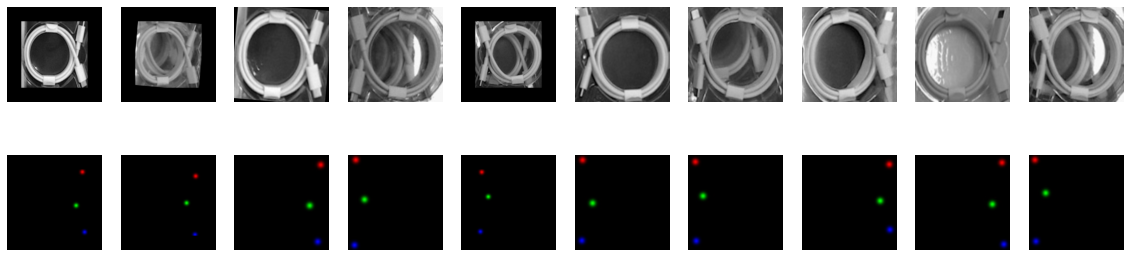

In [47]:
random.shuffle(train_keys[:])
example_dataset = KeyPointsDataset(train_keys[:16], aug=None)
plt.figure(figsize=(20,5))
for batch in example_dataset:
    for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(batch[0][i])
        plt.axis('off')
        plt.subplot(2,10,10+i+1)
        plt.imshow(batch[1][i])
        plt.axis('off')
plt.show()

In [7]:
pretrain = True

if pretrain:
    model = load_model(f"{path}/model_2021-11-29.h5")
else:
    inputL = Input(shape=(224,224,3))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputL)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    block1 = MaxPool2D((2, 2), strides=(2,2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(block1)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D((2, 2), strides=(2, 2) )(x)
    o = Conv2D(32*5, (224//4, 224//4), activation='relu', padding='same')(x)
    o = Conv2D(32*5, (1,1), activation='relu', padding='same')(o)
    output = Conv2DTranspose(3, (4,4), strides=(4,4), use_bias=False)(o)
    model = Model(inputL, output)

model.summary()
loss, val_loss = [], []

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 128)       0   

In [56]:
model.compile(loss='mse',optimizer=RMSprop(lr=.2*1e-3),sample_weight_mode="temporal")
#model.compile(loss='mse',optimizer=Adam(lr=1*1e-5),sample_weight_mode="temporal")
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10)
loss+=history.history["loss"]
val_loss+=history.history["val_loss"]

Epoch 1/10
68/68 [==============================] - 46s 679ms/step - loss: 1.5931e-04 - val_loss: 4.1203e-04
Epoch 2/10
68/68 [==============================] - 46s 674ms/step - loss: 1.4786e-04 - val_loss: 4.3714e-04
Epoch 3/10
68/68 [==============================] - 46s 670ms/step - loss: 1.3794e-04 - val_loss: 4.0055e-04
Epoch 4/10
68/68 [==============================] - 46s 669ms/step - loss: 1.3298e-04 - val_loss: 4.1646e-04
Epoch 5/10
68/68 [==============================] - 45s 669ms/step - loss: 1.2629e-04 - val_loss: 3.8867e-04
Epoch 6/10
68/68 [==============================] - 46s 669ms/step - loss: 1.1964e-04 - val_loss: 4.0636e-04
Epoch 7/10
68/68 [==============================] - 45s 669ms/step - loss: 1.1626e-04 - val_loss: 3.7644e-04
Epoch 8/10
68/68 [==============================] - 45s 669ms/step - loss: 1.1192e-04 - val_loss: 3.8699e-04
Epoch 9/10
68/68 [==============================] - 45s 669ms/step - loss: 1.0693e-04 - val_loss: 3.8046e-04
Epoch 10/10
68/68 [

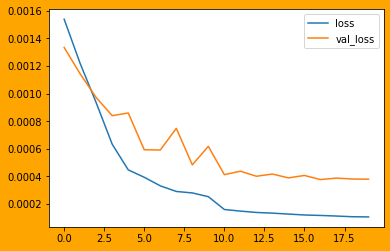

In [58]:
fig = plt.figure()
fig.set_facecolor("orange")
plt.plot( loss )
plt.plot( val_loss )
plt.legend( labels=["loss","val_loss"] )
plt.savefig(f"{path}/loss.jpg")
plt.show()

type0/20210906-155616_00001_color_11.jpg


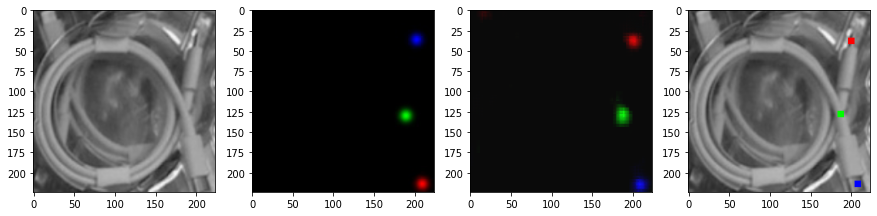

type2_deflect/a52.jpg


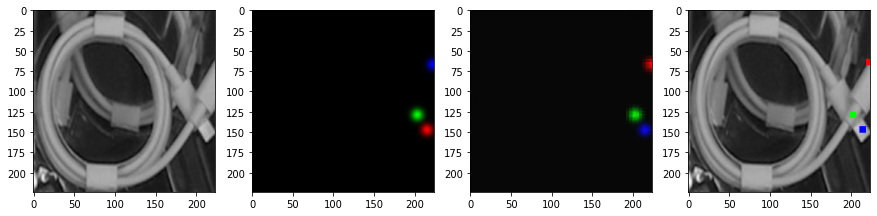

data_1129/20211120-182258_00004_color_2_.jpg


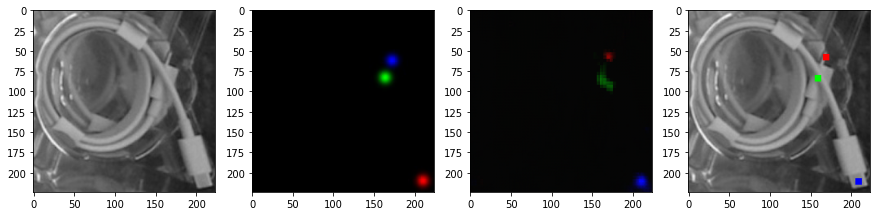

type0/b37.jpg


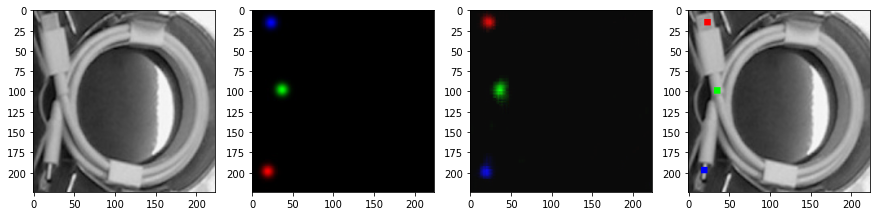

type1_short/20211109-180923_00006_color_10.jpg


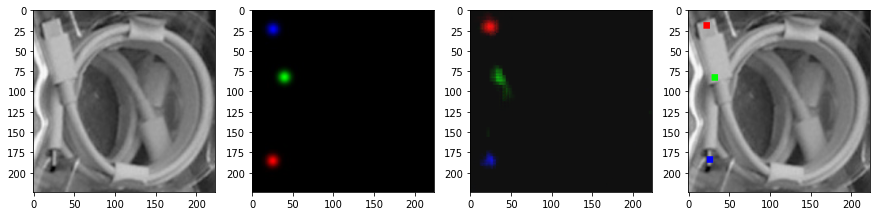

type0/20210906-135454_00017_color_1.jpg


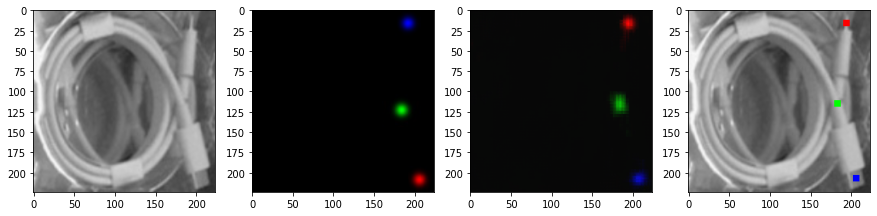

type0/c35.jpg


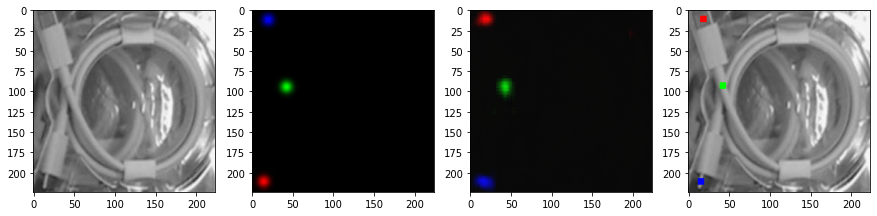

type0/a73.jpg


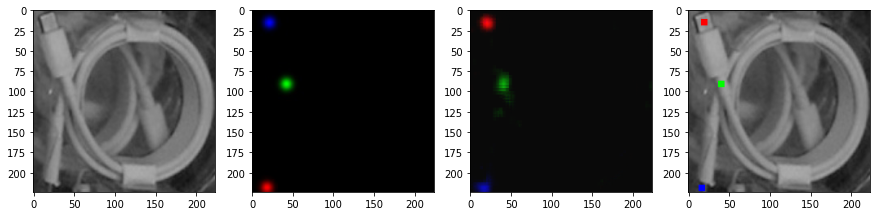

data_1129/20211120-182409_00005_color_2_.jpg


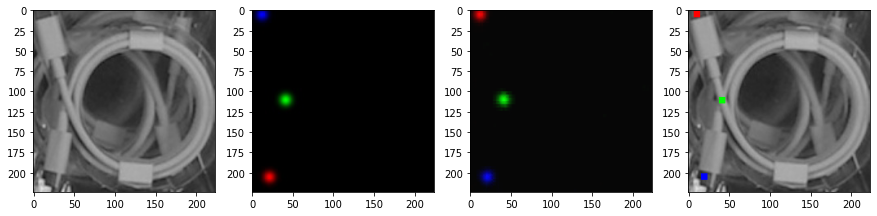

type0/b38.jpg


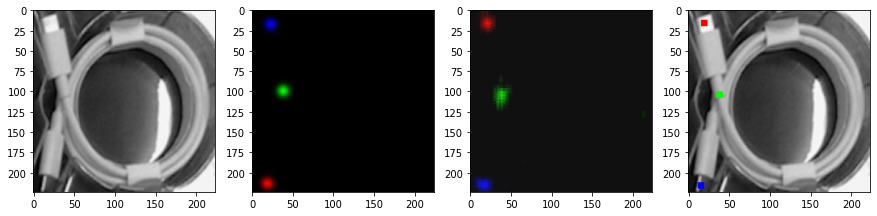

In [8]:
for i in range(min(len(val_keys),10)):
    print("/".join(val_keys[i][0].split("/")[-2:]))
    img = plt.imread(val_keys[i][0])
    img = cv2.resize(img, (224,224))
    hm = plt.imread(val_keys[i][1])
    pred = model.predict( img.reshape(1,224,224,3)/255. ).reshape(224,224,3)
    pred = (pred-pred.min())/(pred.max()-pred.min())
    imgkp = img.copy()
    
    upidx, mididx, downidx = pred[:,:,0].argmax(), pred[:,:,1].argmax(), pred[:,:,2].argmax()
    upy, upx, midy, midx, downy, downx = upidx//224, upidx%224, mididx//224, mididx%224, downidx//224, downidx%224    
    
    imgkp[upy-4:upy+4, upx-4:upx+4, 0] = 255
    imgkp[upy-4:upy+4, upx-4:upx+4, 1] = 0
    imgkp[upy-4:upy+4, upx-4:upx+4, 2] = 0
    imgkp[midy-4:midy+4, midx-4:midx+4, 0] = 0
    imgkp[midy-4:midy+4, midx-4:midx+4, 1] = 255
    imgkp[midy-4:midy+4, midx-4:midx+4, 2] = 0
    imgkp[downy-4:downy+4, downx-4:downx+4, 0] = 0
    imgkp[downy-4:downy+4, downx-4:downx+4, 1] = 0
    imgkp[downy-4:downy+4, downx-4:downx+4, 2] = 255

    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(img)

    plt.subplot(1,4,2)
    plt.imshow(hm)

    plt.subplot(1,4,3)
    plt.imshow( pred ) # [:,:,0]
    
    plt.subplot(1,4,4)
    plt.imshow( imgkp )

    plt.show()

In [60]:
model.save(f"{path}/model_{str(datetime.datetime.now())[:10]}.h5")